In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from PIL import Image
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import os
import torchvision.models as models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# data_transforms = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

In [ ]:
train_dataset = ImageFolder(root="/content/drive/MyDrive/GTSRB1/Train", transform=data_transforms)

In [ ]:
# Use a smaller portion of the dataset
portion = 0.05  # Use 10% of the dataset for training and validation
total_size = len(train_dataset)
subset_size = int(portion * total_size)
indices = np.random.choice(total_size, subset_size, replace=False)

In [ ]:
# Split the subset indices into training and validation sets
num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)
train_size = int(0.8 * subset_size)
val_size = subset_size - train_size
train_indices = indices[:num_classes-1]
val_indices = indices[num_classes-1:]
indices = np.random.choice(total_size, subset_size, replace=False).tolist() #makes sure the indicies are integers

Number of classes: 43


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)


        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)


    def forward(self, x):
        x = F.max_pool2d(F.leaky_relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.leaky_relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.leaky_relu(self.conv3(x)), 2)
        x = x.view(-1, 128*16*16)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#BELOW THIS IS A PRE-TRAINED MODEL THAT GIVES A HIGHER ACCURACY, BUT DOESN'T USE CNN
# def __init__(self, num_classes):
    #     super(ConvNet, self).__init__()
    #     self.model = models.resnet18(pretrained=True)
    #     self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    #     self.dropout = nn.Dropout(0.5)

    # def forward(self, x):
    #     x = self.model(x)
    #     x = self.dropout(x)
    #     return x
# num_classes = len(train_dataset.classes)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = ConvNet(num_classes=num_classes).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/5], Loss: {running_loss/len(train_loader)}')

In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print("Accuracy of the model on the test images: {:.2f}%".format(100 * correct / total))

Accuracy of the model on the test images: 8.18%


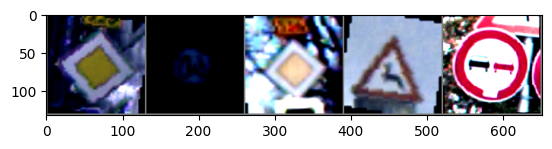

Predicted:  6 41 9 9 4
Actual:  4 23 4 25 42


In [ ]:
import matplotlib.pyplot as plt
import torchvision
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random validation images

dataiter = iter(val_loader)
data = next(dataiter)

# Print images
imshow(torchvision.utils.make_grid(images))
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

# Print predicted vs actual labels
print('Predicted: ', ' '.join(f'{predicted[j]}' for j in range(5)))
print('Actual: ', ' '.join(f'{labels[j]}' for j in range(5)))